# ELEC0054 20/21 Project - The Smart Building & City Lens
This notebook serves as the code implementation of the project assigned in the module ELEC0054 in the Department of Electronic and Electrical Engineering in UCL.

In [1]:
# -*- encoding:utf-8 -*-

import datetime
import warnings  # ignore the warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymongo
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller as ADF

warnings.filterwarnings('ignore')


# plt.rcParams['font.sans-serif'] = ['SimHei']  # plot labels in Chinese
plt.rcParams['axes.unicode_minus'] = False

## Data Acquisition

In [2]:
# Connect to local MongoDB database
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["ucl-smartcity"]
mydb_list = ['AirqualityMonitoringSite', 'cities', 'COReadings', 'COSensor', 'NO2Readings', 'NO2Sensor', 'O3Readings', 'O3Sensor',
             'PM10Readings', 'PM10Sensor', 'PM25Readings', 'PM25Sensor', 'SO2Readings', 'SO2Sensor']

# Store data into local CSV files
for x in mydb_list:
    data = pd.DataFrame(list(mydb[x].find()))
    data.to_csv('data/%s.csv' % x)

## Data Analysis and Modeling (demo)
Show the whole process in details, here take CO as an example since there are only 2 valid monitoring stations for CO.

### Loading data from CSV files

In [3]:
FilePath_CoSensor = 'data/COSensor.csv'
FilePath_Site = 'data/AirqualityMonitoringSite.csv'
FilePath_Co = 'data/COReadings.csv'
FilePath_monitoring = 'data/monitoring.csv'

data_Co = pd.read_csv(FilePath_Co).iloc[:, 2:]
data_CoSensor = pd.read_csv(FilePath_CoSensor)
data_Site = pd.read_csv(FilePath_Site)
data_monitoring = pd.read_csv(FilePath_monitoring).iloc[:, 1:]

### Preprocessing the data

In [4]:
data_Co['siteid'] = ''
data_Co.loc[data_Co['sensorid'] == 'KC1-CO', 'siteid'] = 'KC1'
# data_Co.loc[data_Co['sensorid'] == 'MY1-CO', 'siteid'] = 'MY1'

data_Co = pd.merge(data_Co, data_Site)

# Remove the unwanted columns
data_Co_columns = ['sensorid', 'Unnamed: 0', '_id', 'cityid', 'postcode']
data_Co = data_Co.drop(data_Co_columns, axis=1).groupby('siteid', sort=False)\
    .apply(lambda x: x.sort_values('recordtime', ascending=False))\
    .reset_index(drop=True)

# Keep the last year data and drop the rest
today = datetime.date.today()
last_year = today.year-1
last_time = datetime.datetime(month=today.month, year=last_year, day=today.day)
data_Co['recordtime'] = pd.to_datetime(data_Co['recordtime'])
data_Co = data_Co.loc[data_Co['recordtime'] >= last_time].dropna()

In [5]:
print(data_Co)

              recordtime  value siteid   latitude  longitude
1    2021-09-12 08:00:00    0.3    KC1  51.521047  -0.213492
2    2021-09-12 07:00:00    0.3    KC1  51.521047  -0.213492
3    2021-09-12 06:00:00    0.3    KC1  51.521047  -0.213492
4    2021-09-12 05:00:00    0.4    KC1  51.521047  -0.213492
5    2021-09-12 04:00:00    0.2    KC1  51.521047  -0.213492
...                  ...    ...    ...        ...        ...
8864 2020-09-12 04:00:00    0.1    KC1  51.521047  -0.213492
8865 2020-09-12 03:00:00    0.1    KC1  51.521047  -0.213492
8866 2020-09-12 02:00:00    0.1    KC1  51.521047  -0.213492
8867 2020-09-12 01:00:00    0.1    KC1  51.521047  -0.213492
8868 2020-09-12 00:00:00    0.1    KC1  51.521047  -0.213492

[8669 rows x 5 columns]


In [6]:
# Set 'recordtime' as index to deal with the time-series data
data_Co_columns = ['recordtime', 'CO', 'siteid', 'latitude', 'longitude']
data_Co.columns = data_Co_columns
data_Co['recordtime'] = pd.to_datetime(
    data_Co['recordtime'], format='%Y-%m-%d %H:%M:%S')
data_Co = data_Co.set_index(['recordtime'])

# Drop the duplicated and null data
# data_Co = data_Co.drop_duplicates()
data_count = data_Co.shape[0]
data_Co = data_Co.loc[data_Co['CO'] >= 0]
error = data_count - data_Co.shape[0]
print('There are %i null data.' % (error))

# Extract data according to the monitoring site
data_Co_A = data_Co.loc[data_Co['siteid'] == 'KC1']
# data_Co_B = data_Co.loc[data_Co['siteid'] == 'MY1']

# Use KC1 data as demo
df = data_Co_A['CO'].dropna()
u = df.mean()  # mean
std = df.std()  # standard deviation

# Detect and drop the outliers
data_c = df[np.abs(df - u) <= 3*std]
error = df[np.abs(df - u) > 3*std]
print('There are %i outliers.' % (len(error)))

There are 4 null data.
There are 151 outliers.


In [7]:
print(data_c)

recordtime
2021-09-12 08:00:00    0.3
2021-09-12 07:00:00    0.3
2021-09-12 06:00:00    0.3
2021-09-12 05:00:00    0.4
2021-09-12 04:00:00    0.2
                      ... 
2020-09-12 04:00:00    0.1
2020-09-12 03:00:00    0.1
2020-09-12 02:00:00    0.1
2020-09-12 01:00:00    0.1
2020-09-12 00:00:00    0.1
Name: CO, Length: 8514, dtype: float64


In [8]:
# Resample data into day granularity and interpolate the missing value
data_c = data_c.resample('D').mean().interpolate('linear')
data_c[np.isnan(data_c)] = 0
data_c[np.isinf(data_c)] = 0

In [9]:
print(data_c)

recordtime
2020-09-12    0.108333
2020-09-13    0.112500
2020-09-14    0.216667
2020-09-15    0.141667
2020-09-16    0.158333
                ...   
2021-09-08    0.386364
2021-09-09    0.241667
2021-09-10    0.266667
2021-09-11    0.258333
2021-09-12    0.255556
Freq: D, Name: CO, Length: 366, dtype: float64


### ARIMA model
ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

- **AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- **I**: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- **MA**: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

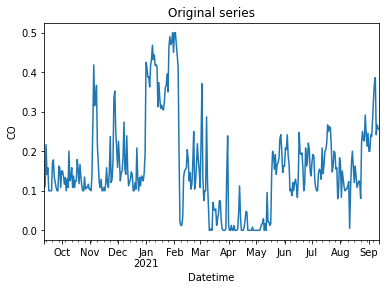

In [10]:
# Draw the original time-series plot
# Check whether the data are stationary
data_c.plot()

# plt.xticks(rotation=45)
plt.xlabel('Datetime')
plt.ylabel('CO')
plt.title('Original series')
plt.show()

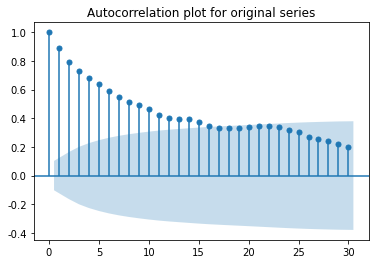

In [11]:
# Draw autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data_c, use_vlines=True, lags=30)
plt.title('Autocorrelation plot for original series')
plt.show()

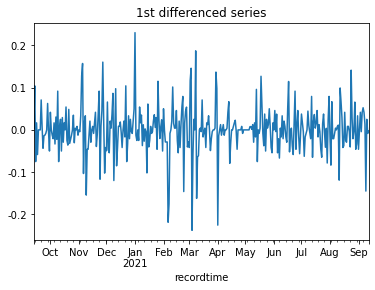

In [12]:
# 1st Differencing
D_ts = data_c.diff().dropna()
D_ts.columns = ['1st Differencing']

# Draw the time-series plot after 1st differencing
D_ts.plot()
plt.title('1st differenced series')
plt.show()

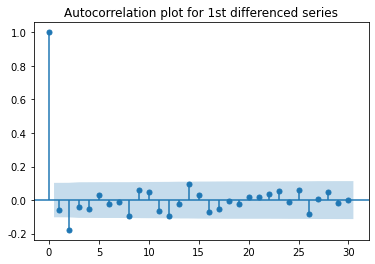

In [13]:
# Draw autocorrelation plot after 1st differencing
from statsmodels.graphics.tsaplots import plot_acf 

plot_acf(D_ts, use_vlines=True, lags=30)
plt.title('Autocorrelation plot for 1st differenced series')
plt.show()

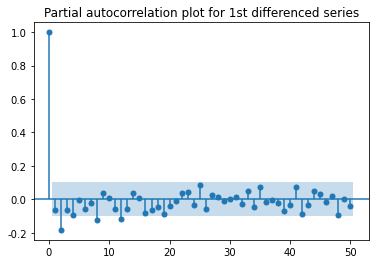

In [14]:
# Draw partial autocorrelation plot after 1st differencing
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(D_ts, use_vlines=True, lags=50)
plt.title('Partial autocorrelation plot for 1st differenced series')
plt.show()

In [15]:
# ADF Test
print('ADF test for the original series: ', ADF(data_c))
print('ADF test for the 1st differenced series: ', ADF(D_ts))

ADF test for the original series:  (-3.701855406970806, 0.004087131741802524, 2, 363, {'1%': -3.448493650810824, '5%': -2.8695352280356556, '10%': -2.5710293341377715}, -1052.0670051196607)
ADF test for the 1st differenced series:  (-11.950261278910299, 4.333586292243208e-22, 3, 361, {'1%': -3.4485948978753314, '5%': -2.86957971128312, '10%': -2.571053050314224}, -1037.964429711637)


In [16]:
# Ljung-Box Test
from statsmodels.stats.diagnostic import acorr_ljungbox

print('Ljung-Box test for the original series: ', acorr_ljungbox(data_c, lags=1))

Ljung-Box test for the original series:  (array([290.75490105]), array([3.40463795e-65]))


In [ ]:
# !!!Warning!!! This cell operation is very time consuming, cost nearly 30 mins on GPU server.
# Find the order of p and q using BIC
data_c = data_c.astype(float)
pmax = int(len(D_ts)/10)
qmax = int(len(D_ts)/10)
bic_matrix = []

for p in range(pmax+1):
    tmp = []
    for q in range(qmax+1):
        try:
            tmp.append(ARIMA(data_c, (p, 1, q)).fit().bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)

# Find the minimum from BIC matrix to determine p and q
bic_matrix = pd.DataFrame(bic_matrix)
p, q = bic_matrix.stack().idxmin()

print(u'The order of p and q are：%s、%s.' % (p, q))

In [17]:
# Modeling
model = ARIMA(D_ts, order=(3, 1, 1), freq='D')  # p=3, d=1, q=1
result = model.fit()
print(result.summary())
print(result.conf_int())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.49813D+00    |proj g|=  6.02625D+01

At iterate    5    f= -1.49902D+00    |proj g|=  1.96166D+00

At iterate   10    f= -1.49926D+00    |proj g|=  2.95637D+01

At iterate   15    f= -1.50192D+00    |proj g|=  4.43181D+00

At iterate   20    f= -1.50193D+00    |proj g|=  2.02199D-01

At iterate   25    f= -1.50193D+00    |proj g|=  3.12604D+00

At iterate   30    f= -1.50203D+00    |proj g|=  3.14404D+00

At iterate   35    f= -1.50204D+00    |proj g|=  1.68151D-02

At iterate   40    f= -1.50204D+00    |proj g|=  2.77926D-01

At iterate   45    f= -1.50205D+00    |proj g|=  2.55436D+00

At iterate   50    f= -1.50242D+00    |proj g|=  4.31638D+00

At iterate   55    f= -1.50262D+00    |proj g|=  1.74227D-02

At iterate   60    f= -1.50427D+00    |proj g|=  6.34246D+00

At iterate   65    f= -1.5

In [18]:
# Forcast for 3 steps (coming days)
result_c = result.forecast(3)

CO_values = np.empty(1, dtype=object)
CO_values[0] = result_c[0].tolist()
CO_values = 'Tomorrow: '+str(abs(CO_values[0][0])) + '\nThe day after tomorrow:'+str(
    abs(CO_values[0][1])) + '\nTwo days later:'+str(abs(CO_values[0][2]))

print(CO_values)

Tomorrow: 0.0014108641306113476
The day after tomorrow:0.0021382618028144445
Two days later:0.0009572348918320008


In [19]:
# Save the forcasts into local file
data_monitoring.loc[data_monitoring['sitecode'] == 'KC1', 'CO'] = CO_values

data_monitoring.to_csv('data/monitoring.csv')
print('CO for next three days: \n', result_c[0])

CO for next three days: 
 [0.00141086 0.00213826 0.00095723]


## Data Analysis and Modeling (general)

In [20]:
def prediction(pollutant):
    FilePath_CoSensor = f'data/{pollutant}Sensor.csv'
    FilePath_Site = 'data/AirqualityMonitoringSite.csv'
    FilePath_Co = f'data/{pollutant}Readings.csv'
    FilePath_monitoring = 'data/monitoring.csv'

    # Loading data
    data_Co = pd.read_csv(FilePath_Co).iloc[:, 2:]
    data_CoSensor = pd.read_csv(FilePath_CoSensor)
    data_Site = pd.read_csv(FilePath_Site)
    data_monitoring = pd.read_csv(FilePath_monitoring).iloc[:, 1:]

    # Keep the last year data and drop the rest
    today = datetime.date.today()
    last_year = today.year-1
    last_time = datetime.datetime(
        month=today.month, year=last_year, day=today.day)
    data_Co['recordtime'] = pd.to_datetime(data_Co['recordtime'])
    data_Co = data_Co.loc[data_Co['recordtime'] >= last_time].dropna()

    data_Co['siteid'] = ''
    sensorid = list(set(list(data_Co['sensorid'])))
    for x in sensorid:
        data_Co.loc[data_Co['sensorid'] == x, 'siteid'] = x[:3]

    data_Co = pd.merge(data_Co, data_Site)

    # Remove the unwanted columns
    data_Co_columns = ['sensorid', 'Unnamed: 0', '_id', 'cityid', 'postcode']
    data_Co = data_Co.drop(data_Co_columns, axis=1).groupby('siteid', sort=False)\
        .apply(lambda x: x.sort_values('recordtime', ascending=False))\
        .reset_index(drop=True)

    # Set 'recordtime' as index to deal with the time-series data
    data_Co_columns = ['recordtime', pollutant,
                       'siteid', 'latitude', 'longitude']
    data_Co.columns = data_Co_columns
    data_Co = data_Co.set_index(['recordtime'])
    data_Co = data_Co.loc[data_Co[pollutant] > 0]

    siteid = list(set(list(data_Co['siteid'])))

    for y in siteid:
        # Extract data according to the monitoring site
        # Drop the duplicated data
        data_Co_A = data_Co.loc[data_Co['siteid'] ==
                                y].drop_duplicates()

        # Detect and drop the outliers
        df = data_Co_A[pollutant].dropna()
        u = df.mean()
        std = df.std()
        data_c = df[np.abs(df - u) <= 3*std]

        # Resample data into day granularity and interpolate the missing value
        data_c = data_c.resample('D').mean().interpolate('linear')
        data_c[np.isnan(data_c)] = 0
        data_c[np.isinf(data_c)] = 0

        # 1st Differencing
        D_ts = data_c.diff().dropna()

        # Modeling
        model = ARIMA(D_ts, order=(4, 1, 0), freq='D')  # p,d,q
        result = model.fit()

        # Forcast for 3 steps (coming days)
        result_c = result.forecast(3)
        CO_values = np.empty(1, dtype=object)
        CO_values[0] = result_c[0].tolist()
        CO_values = 'Tomorrow: '+str(abs(CO_values[0][0])) + '\nThe day after tomorrow:'+str(
            abs(CO_values[0][1])) + '\nTwo days later:'+str(abs(CO_values[0][2]))

        print(result.summary())
        print(result.conf_int())
        print('Forcasts for next three days: \n', result_c)

        # Save the forcasts into local file
        data_monitoring.loc[data_monitoring['sitecode']
                            == y, pollutant] = CO_values

        data_monitoring.to_csv(FilePath_monitoring)

    return FilePath_monitoring

In [21]:
prediction('CO')
prediction('NO2')
prediction('O3')
prediction('SO2')
prediction('PM10')
prediction('PM25')

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.42803D+00    |proj g|=  3.45747D-01

At iterate    5    f= -2.42805D+00    |proj g|=  5.57817D-02

At iterate   10    f= -2.42805D+00    |proj g|=  5.05462D-04

At iterate   15    f= -2.42805D+00    |proj g|=  5.07181D-03

At iterate   20    f= -2.42805D+00    |proj g|=  3.01092D-05

At iterate   25    f= -2.42805D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     39      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.07636D+00    |proj g|=  4.04667D-03

At iterate    5    f= -3.07636D+00    |proj g|=  2.84217D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     18      1     0     0   0.000D+00  -3.076D+00
  F =  -3.0763613532409240     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                             ARIMA Model Results                              
Dep. Variable:                   D.CO   No. Observati

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.70438D+00    |proj g|=  9.57723D-04

At iterate    5    f=  4.70438D+00    |proj g|=  2.21778D-04

At iterate   10    f=  4.70438D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     17      1     0     0   8.882D-08   4.704D+00
  F =   4.7043757681730280     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                      

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.47331D+00    |proj g|=  3.42579D-03

At iterate    5    f=  3.47324D+00    |proj g|=  5.90639D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   1.332D-07   3.473D+00
  F =   3.4732364966728881     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observati

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.70830D+00    |proj g|=  6.39488D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   1.332D-07   3.708D+00
  F =   3.7083006941525891     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  358
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1327.572
Method:                       css-mle   S.D. of innovations              9.853
Date:                Sun, 12 Sep 2021   AIC  

 This problem is unconstrained.



At iterate    5    f=  4.49227D+00    |proj g|=  3.37774D-04

At iterate   10    f=  4.49227D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   0.000D+00   4.492D+00
  F =   4.4922731318144642     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1626.203
Method:                       css-mle   S.D. of innovations   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.19559D+00    |proj g|=  2.39808D-06

At iterate   10    f=  4.19559D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     16      1     0     0   8.882D-08   4.196D+00
  F =   4.1955882481394307     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  361
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1514.607
Method:                       css-mle   S.D. of innovations   

 This problem is unconstrained.
 This problem is unconstrained.


                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1355.878
Method:                       css-mle   S.D. of innovations             10.232
Date:                Sun, 12 Sep 2021   AIC                           2723.757
Time:                        22:43:45   BIC                           2747.107
Sample:                    09-16-2020   HQIC                          2733.039
                         - 09-12-2021                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0108      0.197      0.055      0.956      -0.376       0.397
ar.L1.D.NO2    -0.6314      0.052    -12.259      0.000      -0.732      -0.530
ar.L2.D.NO2    -0.5216      0.059     -8.863    

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96752D+00    |proj g|=  1.43006D-03

At iterate    5    f=  3.96751D+00    |proj g|=  3.02869D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   1.332D-07   3.968D+00
  F =   3.9675107426919300     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observati

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     16      1     0     0   8.882D-08   4.052D+00
  F =   4.0521831085459361     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  364
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1474.995
Method:                       css-mle   S.D. of innovations             13.908
Date:                Sun, 12 Sep 2021   AIC                           2961.989
Time:                       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.51263D+00    |proj g|=  1.38183D-03

At iterate    5    f=  3.51262D+00    |proj g|=  1.28786D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     11      1     0     0   1.332D-07   3.513D+00
  F =   3.5126219325969910     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observati

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85085D+00    |proj g|=  1.16382D-03

At iterate    5    f=  3.85084D+00    |proj g|=  7.32747D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     12      1     0     0   4.441D-08   3.851D+00
  F =   3.8508363587431846     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observati

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.62888D+00    |proj g|=  2.66454D-07

At iterate   10    f=  4.62888D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     18      1     0     0   2.665D-07   4.629D+00
  F =   4.6288761175306146     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  361
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1671.024
Method:                       css-mle   S.D. of innovations   

 This problem is unconstrained.



At iterate    5    f=  4.15263D+00    |proj g|=  2.42473D-05

At iterate   10    f=  4.15263D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   0.000D+00   4.153D+00
  F =   4.1526257650308374     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  361
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1499.098
Method:                       css-mle   S.D. of innovations   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.57572D+00    |proj g|=  4.88498D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   0.000D+00   3.576D+00
  F =   3.5757216856987619     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1294.411
Method:                       css-mle   S.D. of innovations              8.633
Date:                Sun, 12 Sep 2021   AIC  

 This problem is unconstrained.


                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1325.354
Method:                       css-mle   S.D. of innovations              9.403
Date:                Sun, 12 Sep 2021   AIC                           2662.707
Time:                        22:43:48   BIC                           2686.057
Sample:                    09-16-2020   HQIC                          2671.989
                         - 09-12-2021                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0305      0.165     -0.185      0.853      -0.354       0.293
ar.L1.D.NO2    -0.8892      0.052    -17.123      0.000      -0.991      -0.787
ar.L2.D.NO2    -0.6094      0.067     -9.067    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00081D+00    |proj g|=  1.82077D-03

At iterate    5    f=  4.00081D+00    |proj g|=  1.03917D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     11      1     0     0   8.882D-08   4.001D+00
  F =   4.0008085978443146     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observati

 This problem is unconstrained.
 This problem is unconstrained.


                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  358
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1255.268
Method:                       css-mle   S.D. of innovations              8.057
Date:                Sun, 12 Sep 2021   AIC                           2522.536
Time:                        22:43:49   BIC                           2545.820
Sample:                    09-17-2020   HQIC                          2531.796
                         - 09-09-2021                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0220      0.165     -0.133      0.894      -0.345       0.301
ar.L1.D.NO2    -0.6246      0.053    -11.762      0.000      -0.729      -0.521
ar.L2.D.NO2    -0.4805      0.061     -7.898    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53416D+00    |proj g|=  1.33511D-03

At iterate    5    f=  3.53415D+00    |proj g|=  3.99680D-06

At iterate   10    f=  3.53415D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   0.000D+00   3.534D+00
  F =   3.5341495800013463     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                             ARIMA Model Results                      

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04521D+00    |proj g|=  1.07354D-03

At iterate    5    f=  4.04520D+00    |proj g|=  1.41043D-04

At iterate   10    f=  4.04520D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   0.000D+00   4.045D+00
  F =   4.0451996988494416     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                             ARIMA Model Results                      

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   0.000D+00   3.573D+00
  F =   3.5730703947556459     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  361
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1289.878
Method:                       css-mle   S.D. of innovations              8.607
Date:                Sun, 12 Sep 2021   AIC                           2591.757
Time:                       

 This problem is unconstrained.



At iterate    5    f=  4.01672D+00    |proj g|=  5.92415D-05

At iterate   10    f=  4.01672D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   8.882D-08   4.017D+00
  F =   4.0167181735018129     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1454.052
Method:                       css-mle   S.D. of innovations   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.24883D+00    |proj g|=  1.19540D-03

At iterate    5    f=  4.24882D+00    |proj g|=  1.41309D-04

At iterate   10    f=  4.24882D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   8.882D-08   4.249D+00
  F =   4.2488224185012582     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                      

 This problem is unconstrained.



At iterate   10    f=  4.60173D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     17      1     0     0   1.776D-07   4.602D+00
  F =   4.6017263759525040     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1665.825
Method:                       css-mle   S.D. of innovations             24.082
Date:                Sun, 12 Sep 2021   AIC  

 This problem is unconstrained.



At iterate   10    f=  3.78748D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   8.882D-08   3.787D+00
  F =   3.7874768196759718     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1371.067
Method:                       css-mle   S.D. of innovations             10.666
Date:                Sun, 12 Sep 2021   AIC  

 This problem is unconstrained.



At iterate   10    f=  3.50851D+00    |proj g|=  1.33227D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   1.332D-07   3.509D+00
  F =   3.5085082224665300     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1270.080
Method:                       css-mle   S.D. of innovations              8.068
Date:                Sun, 12 Sep 2021   AIC  

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   1.776D-07   4.288D+00
  F =   4.2877432416097596     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  280
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1200.568
Method:                       css-mle   S.D. of innovations             17.583
Date:                Sun, 12 Sep 2021   AIC                           2413.136
Time:                       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.15480D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   0.000D+00   4.155D+00
  F =   4.1548016048652858     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  361
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1499.883
Method:                       css-mle   S.D. of innovations             15.398
Date:                Sun, 12 Sep 2021   AIC  

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.43041D+00    |proj g|=  1.39542D-03

At iterate    5    f=  4.43041D+00    |proj g|=  1.30296D-04

At iterate   10    f=  4.43041D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   8.882D-08   4.430D+00
  F =   4.4304051830538151     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                      

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   0.000D+00   2.761D+00
  F =   2.7609681876569607     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  354
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -977.383
Method:                       css-mle   S.D. of innovations              3.822
Date:                Sun, 12 Sep 2021   AIC                           1966.765
Time:                       

 This problem is unconstrained.
 This problem is unconstrained.


                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1430.586
Method:                       css-mle   S.D. of innovations             12.576
Date:                Sun, 12 Sep 2021   AIC                           2873.171
Time:                        22:43:53   BIC                           2896.521
Sample:                    09-16-2020   HQIC                          2882.453
                         - 09-12-2021                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0132      0.228     -0.058      0.954      -0.460       0.433
ar.L1.D.NO2    -0.7215      0.052    -13.917      0.000      -0.823      -0.620
ar.L2.D.NO2    -0.6053      0.061     -9.965    

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83783D+00    |proj g|=  1.22191D-03

At iterate    5    f=  3.83782D+00    |proj g|=  1.87406D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     13      1     0     0   4.441D-08   3.838D+00
  F =   3.8378233824054786     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observati

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.46388D+00    |proj g|=  1.88116D-04

At iterate   10    f=  4.46388D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   8.882D-08   4.464D+00
  F =   4.4638762336827922     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  328
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1464.151
Method:                       css-mle   S.D. of innovations   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.60933D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   8.882D-08   3.609D+00
  F =   3.6093257920141268     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1306.576
Method:                       css-mle   S.D. of innovations              8.927
Date:                Sun, 12 Sep 2021   AIC  

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02556D+00    |proj g|=  3.98890D-03

At iterate    5    f=  4.02553D+00    |proj g|=  5.09814D-05

At iterate   10    f=  4.02553D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   8.882D-08   4.026D+00
  F =   4.0255327282650368     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                      

 This problem is unconstrained.
 This problem is unconstrained.


                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1397.217
Method:                       css-mle   S.D. of innovations             11.469
Date:                Sun, 12 Sep 2021   AIC                           2806.433
Time:                        22:43:55   BIC                           2829.783
Sample:                    09-16-2020   HQIC                          2815.716
                         - 09-12-2021                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0029      0.217      0.013      0.989      -0.422       0.427
ar.L1.D.NO2    -0.6019      0.052    -11.682      0.000      -0.703      -0.501
ar.L2.D.NO2    -0.5573      0.056     -9.896    

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.21714D+00    |proj g|=  1.10756D-03

At iterate    5    f=  4.21714D+00    |proj g|=  1.77103D-04

At iterate   10    f=  4.21714D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   8.882D-08   4.217D+00
  F =   4.2171358982737059     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                      

 This problem is unconstrained.
 This problem is unconstrained.


                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  361
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1468.752
Method:                       css-mle   S.D. of innovations             14.132
Date:                Sun, 12 Sep 2021   AIC                           2949.505
Time:                        22:43:56   BIC                           2972.838
Sample:                    09-17-2020   HQIC                          2958.782
                         - 09-12-2021                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0115      0.258     -0.044      0.965      -0.518       0.495
ar.L1.D.NO2    -0.6974      0.051    -13.686      0.000      -0.797      -0.597
ar.L2.D.NO2    -0.5183      0.059     -8.836    

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.42968D+00    |proj g|=  1.13740D-03

At iterate    5    f=  4.42968D+00    |proj g|=  1.33227D-06

At iterate   10    f=  4.42968D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     16      1     0     0   8.882D-08   4.430D+00
  F =   4.4296765631125652     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                      

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.48770D+00    |proj g|=  1.64313D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   8.882D-08   3.488D+00
  F =   3.4877047007158275     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1262.549
Method:                       css-mle   S.D. of innovations              7.905
Date:                Sun, 12 Sep 2021   AIC  

 This problem is unconstrained.



At iterate    5    f=  4.21329D+00    |proj g|=  4.75620D-04

At iterate   10    f=  4.21329D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     16      1     0     0   8.882D-08   4.213D+00
  F =   4.2132901784735814     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  363
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1529.424
Method:                       css-mle   S.D. of innovations   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.95691D+00    |proj g|=  5.25358D-05

At iterate   10    f=  3.95691D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   8.882D-08   3.957D+00
  F =   3.9569068640123435     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  277
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1096.063
Method:                       css-mle   S.D. of innovations   

 This problem is unconstrained.
 This problem is unconstrained.


                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1286.729
Method:                       css-mle   S.D. of innovations              8.449
Date:                Sun, 12 Sep 2021   AIC                           2585.458
Time:                        22:43:57   BIC                           2608.808
Sample:                    09-16-2020   HQIC                          2594.741
                         - 09-12-2021                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0086      0.140     -0.061      0.951      -0.283       0.266
ar.L1.D.NO2    -0.7679      0.051    -15.177      0.000      -0.867      -0.669
ar.L2.D.NO2    -0.6330      0.059    -10.725    

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96375D+00    |proj g|=  1.41582D-02

At iterate    5    f=  3.96266D+00    |proj g|=  4.46931D-04

At iterate   10    f=  3.96266D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   8.882D-08   3.963D+00
  F =   3.9626600033057224     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                      

 This problem is unconstrained.
 This problem is unconstrained.


                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1632.905
Method:                       css-mle   S.D. of innovations             21.993
Date:                Sun, 12 Sep 2021   AIC                           3277.810
Time:                        22:43:58   BIC                           3301.160
Sample:                    09-16-2020   HQIC                          3287.092
                         - 09-12-2021                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0046      0.406      0.011      0.991      -0.792       0.801
ar.L1.D.NO2    -0.6679      0.051    -13.095      0.000      -0.768      -0.568
ar.L2.D.NO2    -0.5197      0.058     -9.006    

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.28646D+00    |proj g|=  9.71490D-04

At iterate    5    f=  4.28645D+00    |proj g|=  1.92824D-04

At iterate   10    f=  4.28645D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     16      1     0     0   8.882D-08   4.286D+00
  F =   4.2864486380911266     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                      

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95903D+00    |proj g|=  1.92450D-03

At iterate    5    f=  3.95900D+00    |proj g|=  5.37348D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     11      1     0     0   8.882D-08   3.959D+00
  F =   3.9589975398332946     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observati

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.50885D+00    |proj g|=  3.88756D-04

At iterate   10    f=  4.50884D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     17      1     0     0   1.776D-07   4.509D+00
  F =   4.5088445714219514     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  355
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1600.640
Method:                       css-mle   S.D. of innovations   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.25734D+00    |proj g|=  1.76215D-04

At iterate   10    f=  4.25734D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   0.000D+00   4.257D+00
  F =   4.2573408589487949     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1541.157
Method:                       css-mle   S.D. of innovations   

 This problem is unconstrained.
 This problem is unconstrained.


                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  349
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1358.353
Method:                       css-mle   S.D. of innovations             11.848
Date:                Sun, 12 Sep 2021   AIC                           2728.706
Time:                        22:44:00   BIC                           2751.836
Sample:                    09-17-2020   HQIC                          2737.914
                         - 08-31-2021                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0008      0.244      0.003      0.997      -0.477       0.479
ar.L1.D.NO2    -0.6019      0.053    -11.366      0.000      -0.706      -0.498
ar.L2.D.NO2    -0.4561      0.058     -7.886    

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.30131D+00    |proj g|=  1.46843D-03

At iterate    5    f=  4.30130D+00    |proj g|=  3.46390D-06

At iterate   10    f=  4.30130D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   1.776D-07   4.301D+00
  F =   4.3012994637695172     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                      

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.93883D+00    |proj g|=  1.63825D-02

At iterate    5    f=  3.93826D+00    |proj g|=  7.58238D-04

At iterate   10    f=  3.93826D+00    |proj g|=  4.44089D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   4.441D-08   3.938D+00
  F =   3.9382606239988567     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                      

 This problem is unconstrained.



At iterate    5    f=  4.04184D+00    |proj g|=  5.85310D-05

At iterate   10    f=  4.04184D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   8.882D-08   4.042D+00
  F =   4.0418415538280472     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1463.147
Method:                       css-mle   S.D. of innovations   

 This problem is unconstrained.



At iterate    5    f=  3.41967D+00    |proj g|=  3.37508D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   8.882D-08   3.420D+00
  F =   3.4196664509771688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.NO2   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1237.919
Method:                       css-mle   S.D. of innovations              7.385
Date:                Sun, 12 Sep 2021   AIC  

 This problem is unconstrained.
 This problem is unconstrained.


                             ARIMA Model Results                              
Dep. Variable:                   D.O3   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1418.377
Method:                       css-mle   S.D. of innovations             12.159
Date:                Sun, 12 Sep 2021   AIC                           2848.754
Time:                        22:44:03   BIC                           2872.104
Sample:                    09-16-2020   HQIC                          2858.036
                         - 09-12-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0184      0.219     -0.084      0.933      -0.447       0.410
ar.L1.D.O3    -0.6972      0.051    -13.689      0.000      -0.797      -0.597
ar.L2.D.O3    -0.5898      0.059     -9.990      0.0

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.35909D+00    |proj g|=  1.61293D-03

At iterate    5    f=  4.35909D+00    |proj g|=  5.32907D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7      9      1     0     0   8.882D-08   4.359D+00
  F =   4.3590856091391652     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                   D.O3   No. Observati

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.24772D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   8.882D-08   4.248D+00
  F =   4.2477216967206646     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                   D.O3   No. Observations:                  361
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1533.428
Method:                       css-mle   S.D. of innovations             16.891
Date:                Sun, 12 Sep 2021   AIC  

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     13      1     0     0   8.882D-08   4.349D+00
  F =   4.3490170706485882     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                   D.O3   No. Observations:                  350
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1522.156
Method:                       css-mle   S.D. of innovations             18.702
Date:                Sun, 12 Sep 2021   AIC                           3056.312
Time:                       

 This problem is unconstrained.
 This problem is unconstrained.


                             ARIMA Model Results                              
Dep. Variable:                   D.O3   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1357.870
Method:                       css-mle   S.D. of innovations             10.280
Date:                Sun, 12 Sep 2021   AIC                           2727.739
Time:                        22:44:04   BIC                           2751.089
Sample:                    09-16-2020   HQIC                          2737.022
                         - 09-12-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0190      0.150     -0.127      0.899      -0.314       0.276
ar.L1.D.O3    -1.0925      0.052    -21.034      0.000      -1.194      -0.991
ar.L2.D.O3    -0.8525      0.074    -11.564      0.0

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.16679D+00    |proj g|=  1.36762D-03

At iterate    5    f=  4.16678D+00    |proj g|=  1.17240D-05

At iterate   10    f=  4.16678D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   8.882D-08   4.167D+00
  F =   4.1667826776108869     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                      

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.18256D+00    |proj g|=  2.48690D-06

At iterate   10    f=  4.18256D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   0.000D+00   4.183D+00
  F =   4.1825640446582089     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                             ARIMA Model Results                              
Dep. Variable:                   D.O3   No. Observations:                  357
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1493.175
Method:                       css-mle   S.D. of innovations   

 This problem is unconstrained.
 This problem is unconstrained.


                             ARIMA Model Results                              
Dep. Variable:                   D.O3   No. Observations:                  360
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1478.998
Method:                       css-mle   S.D. of innovations             14.705
Date:                Sun, 12 Sep 2021   AIC                           2969.996
Time:                        22:44:06   BIC                           2993.313
Sample:                    09-18-2020   HQIC                          2979.268
                         - 09-12-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0255      0.263     -0.097      0.923      -0.542       0.491
ar.L1.D.O3    -0.7465      0.052    -14.463      0.000      -0.848      -0.645
ar.L2.D.O3    -0.5479      0.060     -9.095      0.0

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.13660D+00    |proj g|=  1.09903D-03

At iterate    5    f=  4.13659D+00    |proj g|=  2.22933D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     13      1     0     0   8.882D-08   4.137D+00
  F =   4.1365857628130183     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                   D.O3   No. Observati

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05821D+00    |proj g|=  5.63525D-03

At iterate    5    f=  1.05808D+00    |proj g|=  2.18958D-04

At iterate   10    f=  1.05808D+00    |proj g|=  4.44089D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   4.441D-08   1.058D+00
  F =   1.0580774677154781     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                      

 This problem is unconstrained.


                             ARIMA Model Results                              
Dep. Variable:                  D.SO2   No. Observations:                  308
Model:                 ARIMA(4, 1, 0)   Log Likelihood                  68.215
Method:                       css-mle   S.D. of innovations              0.193
Date:                Sun, 12 Sep 2021   AIC                           -124.429
Time:                        22:44:07   BIC                           -102.049
Sample:                    11-07-2020   HQIC                          -115.481
                         - 09-10-2021                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0025      0.003     -0.774      0.439      -0.009       0.004
ar.L1.D.SO2    -1.2248      0.078    -15.780      0.000      -1.377      -1.073
ar.L2.D.SO2    -0.7142      0.121     -5.914    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.15210D+00    |proj g|=  1.83586D-04

At iterate   10    f=  1.15210D+00    |proj g|=  4.44089D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   2.220D-08   1.152D+00
  F =   1.1521023074279242     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.SO2   No. Observations:                  276
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -317.980
Method:                       css-mle   S.D. of innovations   

 This problem is unconstrained.



At iterate   10    f=  9.37548D-01    |proj g|=  9.54870D-04

At iterate   15    f=  9.37547D-01    |proj g|=  6.43929D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     22      1     0     0   5.551D-08   9.375D-01
  F =  0.93754706739430649     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                  D.SO2   No. Observations:                  234
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -219.386
Method:                       css-mle   S.D. of innovations   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18476D+00    |proj g|=  1.16369D-03

At iterate    5    f=  4.18475D+00    |proj g|=  3.92575D-05

At iterate   10    f=  4.18475D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   8.882D-08   4.185D+00
  F =   4.1847543465428192     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                      

 This problem is unconstrained.
 This problem is unconstrained.


                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1160.257
Method:                       css-mle   S.D. of innovations              5.958
Date:                Sun, 12 Sep 2021   AIC                           2332.514
Time:                        22:44:16   BIC                           2355.864
Sample:                    09-16-2020   HQIC                          2341.796
                         - 09-12-2021                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0015      0.100      0.015      0.988      -0.194       0.197
ar.L1.D.PM10    -0.8470      0.053    -16.058      0.000      -0.950      -0.744
ar.L2.D.PM10    -0.6486      0.065     -9.96

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.38641D+00    |proj g|=  2.21445D-03

At iterate    5    f=  3.38640D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7      9      1     0     0   8.882D-08   3.386D+00
  F =   3.3863979845378998     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observati

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.36669D+00    |proj g|=  1.85771D-03

At iterate    5    f=  3.36668D+00    |proj g|=  1.02141D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7     10      1     0     0   4.441D-08   3.367D+00
  F =   3.3666792933353649     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observati

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.98066D+00    |proj g|=  4.44089D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   4.441D-08   2.981D+00
  F =   2.9806643261424108     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1079.000
Method:                       css-mle   S.D. of innovations              4.758
Date:                Sun, 12 Sep 2021   AIC  

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48789D+00    |proj g|=  1.38654D-03

At iterate    5    f=  3.48788D+00    |proj g|=  1.98064D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     11      1     0     0   8.882D-08   3.488D+00
  F =   3.4878779080347337     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observati

 This problem is unconstrained.
 This problem is unconstrained.


                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1226.747
Method:                       css-mle   S.D. of innovations              7.165
Date:                Sun, 12 Sep 2021   AIC                           2465.493
Time:                        22:44:17   BIC                           2488.843
Sample:                    09-16-2020   HQIC                          2474.776
                         - 09-12-2021                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0102      0.158     -0.065      0.948      -0.320       0.300
ar.L1.D.PM10    -0.5238      0.051    -10.173      0.000      -0.625      -0.423
ar.L2.D.PM10    -0.3855      0.058     -6.69

 This problem is unconstrained.
 This problem is unconstrained.


                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observations:                  311
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -938.828
Method:                       css-mle   S.D. of innovations              4.945
Date:                Sun, 12 Sep 2021   AIC                           1889.657
Time:                        22:44:18   BIC                           1912.095
Sample:                    11-06-2020   HQIC                          1898.626
                         - 09-12-2021                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0588      0.105     -0.560      0.575      -0.265       0.147
ar.L1.D.PM10    -0.5940      0.058    -10.206      0.000      -0.708      -0.480
ar.L2.D.PM10    -0.6699      0.067    -10.04

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56081D+00    |proj g|=  1.28808D-03

At iterate    5    f=  3.56081D+00    |proj g|=  1.02141D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     11      1     0     0   8.882D-08   3.561D+00
  F =   3.5608074584638465     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observati

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.83093D+00    |proj g|=  7.81597D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   4.441D-08   2.831D+00
  F =   2.8309317597915471     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observations:                  361
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1021.966
Method:                       css-mle   S.D. of innovations              4.097
Date:                Sun, 12 Sep 2021   AIC  

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88875D+00    |proj g|=  1.56475D-03

At iterate    5    f=  3.88875D+00    |proj g|=  4.52971D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   8.882D-08   3.889D+00
  F =   3.8887468548828021     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observati

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.77624D+00    |proj g|=  7.54952D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   8.882D-08   3.776D+00
  F =   3.7762414897826737     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observations:                  361
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1363.223
Method:                       css-mle   S.D. of innovations             10.547
Date:                Sun, 12 Sep 2021   AIC  

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.40414D+00    |proj g|=  8.72133D-03

At iterate    5    f=  3.40391D+00    |proj g|=  1.19549D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   8.882D-08   3.404D+00
  F =   3.4039133410686131     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observati

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57543D+00    |proj g|=  1.30425D-03

At iterate    5    f=  3.57542D+00    |proj g|=  6.21725D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7      9      1     0     0   1.332D-07   3.575D+00
  F =   3.5754207539314997     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observati

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.11622D+00    |proj g|=  2.07168D-03

At iterate    5    f=  4.11621D+00    |proj g|=  5.00044D-05

At iterate   10    f=  4.11621D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   8.882D-08   4.116D+00
  F =   4.1162106887250722     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                      

 This problem is unconstrained.



At iterate    5    f=  3.94449D+00    |proj g|=  7.46070D-06

At iterate   10    f=  3.94449D+00    |proj g|=  1.33227D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   8.882D-08   3.944D+00
  F =   3.9444939467645108     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observations:                  361
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1423.962
Method:                       css-mle   S.D. of innovations   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.49641D+00    |proj g|=  1.02141D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   0.000D+00   3.496D+00
  F =   3.4964111015812223     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observations:                  361
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1262.204
Method:                       css-mle   S.D. of innovations              7.977
Date:                Sun, 12 Sep 2021   AIC  

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56097D+00    |proj g|=  1.64104D-03

At iterate    5    f=  3.56097D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6     10      1     0     0   1.332D-07   3.561D+00
  F =   3.5609659067545554     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observati

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     13      1     0     0   4.441D-08   3.514D+00
  F =   3.5142449525558361     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observations:                  289
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1015.617
Method:                       css-mle   S.D. of innovations              8.116
Date:                Sun, 12 Sep 2021   AIC                           2043.234
Time:                       

 This problem is unconstrained.
 This problem is unconstrained.


                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1325.514
Method:                       css-mle   S.D. of innovations              9.408
Date:                Sun, 12 Sep 2021   AIC                           2663.028
Time:                        22:44:22   BIC                           2686.378
Sample:                    09-16-2020   HQIC                          2672.311
                         - 09-12-2021                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0130      0.173     -0.075      0.940      -0.353       0.327
ar.L1.D.PM10    -0.7931      0.052    -15.335      0.000      -0.894      -0.692
ar.L2.D.PM10    -0.5681      0.065     -8.80

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.99045D+00    |proj g|=  9.80416D-04

At iterate    5    f=  3.99044D+00    |proj g|=  4.31655D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   4.441D-08   3.990D+00
  F =   3.9904434397279389     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observati

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.87374D+00    |proj g|=  5.32907D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     11      1     0     0   8.882D-08   3.874D+00
  F =   3.8737431341704185     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observations:                  361
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1398.421
Method:                       css-mle   S.D. of innovations             11.623
Date:                Sun, 12 Sep 2021   AIC  

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28936D+00    |proj g|=  1.75246D-02

At iterate    5    f=  3.28879D+00    |proj g|=  3.89022D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   0.000D+00   3.289D+00
  F =   3.2887902490834708     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observati

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   4.441D-08   3.578D+00
  F =   3.5775698720496019     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1295.080
Method:                       css-mle   S.D. of innovations              8.649
Date:                Sun, 12 Sep 2021   AIC                           2602.161
Time:                       

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     11      1     0     0   1.776D-07   3.469D+00
  F =   3.4692501487629674     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observations:                  361
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1252.399
Method:                       css-mle   S.D. of innovations              7.762
Date:                Sun, 12 Sep 2021   AIC                           2516.799
Time:                       

 This problem is unconstrained.
 This problem is unconstrained.


                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observations:                  360
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -857.012
Method:                       css-mle   S.D. of innovations              2.611
Date:                Sun, 12 Sep 2021   AIC                           1726.025
Time:                        22:44:24   BIC                           1749.342
Sample:                    09-18-2020   HQIC                          1735.296
                         - 09-12-2021                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0203      0.040     -0.509      0.611      -0.098       0.058
ar.L1.D.PM10    -0.9182      0.052    -17.567      0.000      -1.021      -0.816
ar.L2.D.PM10    -0.9216      0.076    -12.16

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43709D+00    |proj g|=  9.05676D-04

At iterate    5    f=  3.43709D+00    |proj g|=  1.55431D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   1.332D-07   3.437D+00
  F =   3.4370858822946020     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observati

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81192D+00    |proj g|=  1.75184D-03

At iterate    5    f=  3.81191D+00    |proj g|=  1.73195D-06

At iterate   10    f=  3.81191D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   0.000D+00   3.812D+00
  F =   3.8119093289297776     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                             ARIMA Model Results                      

 This problem is unconstrained.
 This problem is unconstrained.


                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1190.365
Method:                       css-mle   S.D. of innovations              6.478
Date:                Sun, 12 Sep 2021   AIC                           2392.729
Time:                        22:44:25   BIC                           2416.079
Sample:                    09-16-2020   HQIC                          2402.012
                         - 09-12-2021                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0010      0.125     -0.008      0.994      -0.246       0.244
ar.L1.D.PM10    -0.6674      0.052    -12.944      0.000      -0.768      -0.566
ar.L2.D.PM10    -0.5217      0.060     -8.63

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57846D+00    |proj g|=  1.72098D-03

At iterate    5    f=  3.57845D+00    |proj g|=  9.59233D-06

At iterate   10    f=  3.57845D+00    |proj g|=  1.33227D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   1.332D-07   3.578D+00
  F =   3.5784490701830882     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                      

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58755D+00    |proj g|=  3.94311D-03

At iterate    5    f=  3.58748D+00    |proj g|=  3.24185D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   1.332D-07   3.587D+00
  F =   3.5874775119185323     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observati

 This problem is unconstrained.



At iterate    5    f=  2.82440D+00    |proj g|=  5.25358D-05

At iterate   10    f=  2.82440D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   4.441D-08   2.824D+00
  F =   2.8244000197328218     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                 D.PM10   No. Observations:                  300
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -847.320
Method:                       css-mle   S.D. of innovations   

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     17      1     0     0   0.000D+00   2.338D+00
  F =   2.3378614606746519     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                             ARIMA Model Results                              
Dep. Variable:                 D.PM25   No. Observations:                  310
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -724.737
Method:                       css-mle   S.D. of innovations              2.503
Date:                Sun, 12 Sep 2021   AIC                           1461.474
Time:                       

 This problem is unconstrained.
 This problem is unconstrained.


                             ARIMA Model Results                              
Dep. Variable:                 D.PM25   No. Observations:                  361
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -985.570
Method:                       css-mle   S.D. of innovations              3.707
Date:                Sun, 12 Sep 2021   AIC                           1983.140
Time:                        22:44:29   BIC                           2006.473
Sample:                    09-17-2020   HQIC                          1992.416
                         - 09-12-2021                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0170      0.070     -0.244      0.807      -0.154       0.120
ar.L1.D.PM25    -0.7171      0.052    -13.827      0.000      -0.819      -0.615
ar.L2.D.PM25    -0.5127      0.062     -8.32

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.34039D+00    |proj g|=  3.10862D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7      9      1     0     0   0.000D+00   3.340D+00
  F =   3.3403942220655125     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                             ARIMA Model Results                              
Dep. Variable:                 D.PM25   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1209.223
Method:                       css-mle   S.D. of innovations              6.818
Date:                Sun, 12 Sep 2021   AIC  

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99643D+00    |proj g|=  2.09701D-01

At iterate    5    f=  2.78684D+00    |proj g|=  1.53077D-02

At iterate   10    f=  2.75510D+00    |proj g|=  7.47833D-03

At iterate   15    f=  2.74731D+00    |proj g|=  2.72826D-03

At iterate   20    f=  2.74397D+00    |proj g|=  4.42767D-02

At iterate   25    f=  2.74069D+00    |proj g|=  5.73854D-02

At iterate   30    f=  2.73471D+00    |proj g|=  9.02385D-03

At iterate   35    f=  2.73301D+00    |proj g|=  2.46478D-03

At iterate   40    f=  2.73291D+00    |proj g|=  1.55014D-03

At iterate   45    f=  2.73290D+00    |proj g|=  1.62625D-04

At iterate   50    f=  2.73290D+00    |proj g|=  3.14992D-04

At iterate   55    f=  2.73290D+00    |proj g|=  6.94156D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   60    f=  2.73290D+00    |proj g|=  7.00773D-05

At iterate   65    f=  2.73290D+00    |proj g|=  4.82148D-04

At iterate   70    f=  2.73290D+00    |proj g|=  1.61071D-04

At iterate   75    f=  2.73290D+00    |proj g|=  2.82396D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     79    239      5     0     0   3.072D-04   2.733D+00
  F =   2.7328953084568228     

ABNORMAL_TERMINATION_IN_LNSRCH                              
                             ARIMA Model Results                              
Dep. Variable:                 D.PM25   No. Observations:                  311
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -849.930
Method:                       css-mle   S.D. of innovations              3.665
Date:                Sun, 12 Sep 2021   AIC                           1711.861
Time:                       

 This problem is unconstrained.
 This problem is unconstrained.


                             ARIMA Model Results                              
Dep. Variable:                 D.PM25   No. Observations:                  359
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1061.558
Method:                       css-mle   S.D. of innovations              4.651
Date:                Sun, 12 Sep 2021   AIC                           2135.116
Time:                        22:44:31   BIC                           2158.416
Sample:                    09-18-2020   HQIC                          2144.381
                         - 09-11-2021                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0143      0.091     -0.157      0.875      -0.192       0.163
ar.L1.D.PM25    -0.6480      0.052    -12.419      0.000      -0.750      -0.546
ar.L2.D.PM25    -0.5575      0.060     -9.33

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77519D+00    |proj g|=  1.42819D-03

At iterate    5    f=  2.77519D+00    |proj g|=  3.93907D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   0.000D+00   2.775D+00
  F =   2.7751856194224791     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                             ARIMA Model Results                              
Dep. Variable:                 D.PM25   No. Observati

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.51920D+00    |proj g|=  3.52580D-03

At iterate   10    f=  2.51912D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   4.441D-08   2.519D+00
  F =   2.5191219399504963     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                 D.PM25   No. Observations:                  310
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -780.928
Method:                       css-mle   S.D. of innovations   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.34836D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   8.882D-08   2.348D+00
  F =   2.3483563359079689     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                 D.PM25   No. Observations:                  331
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -777.306
Method:                       css-mle   S.D. of innovations              2.531
Date:                Sun, 12 Sep 2021   AIC  

 This problem is unconstrained.
 This problem is unconstrained.


                             ARIMA Model Results                              
Dep. Variable:                 D.PM25   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1039.664
Method:                       css-mle   S.D. of innovations              4.272
Date:                Sun, 12 Sep 2021   AIC                           2091.328
Time:                        22:44:32   BIC                           2114.678
Sample:                    09-16-2020   HQIC                          2100.610
                         - 09-12-2021                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0143      0.086     -0.165      0.869      -0.183       0.155
ar.L1.D.PM25    -0.6091      0.052    -11.735      0.000      -0.711      -0.507
ar.L2.D.PM25    -0.4669      0.058     -8.00

 This problem is unconstrained.


                             ARIMA Model Results                              
Dep. Variable:                 D.PM25   No. Observations:                  310
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -872.434
Method:                       css-mle   S.D. of innovations              4.024
Date:                Sun, 12 Sep 2021   AIC                           1756.868
Time:                        22:44:33   BIC                           1779.288
Sample:                    11-07-2020   HQIC                          1765.831
                         - 09-12-2021                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0157      0.057      0.275      0.783      -0.096       0.127
ar.L1.D.PM25    -1.0041      0.059    -17.018      0.000      -1.120      -0.888
ar.L2.D.PM25    -0.8679      0.100     -8.67

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.05882D+00    |proj g|=  7.10543D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   1.332D-07   3.059D+00
  F =   3.0588207023411211     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                 D.PM25   No. Observations:                  221
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -675.999
Method:                       css-mle   S.D. of innovations              5.142
Date:                Sun, 12 Sep 2021   AIC  

 This problem is unconstrained.
 This problem is unconstrained.


                             ARIMA Model Results                              
Dep. Variable:                 D.PM25   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1112.731
Method:                       css-mle   S.D. of innovations              5.226
Date:                Sun, 12 Sep 2021   AIC                           2237.462
Time:                        22:44:33   BIC                           2260.812
Sample:                    09-16-2020   HQIC                          2246.744
                         - 09-12-2021                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0059      0.096      0.061      0.951      -0.181       0.193
ar.L1.D.PM25    -0.6363      0.052    -12.300      0.000      -0.738      -0.535
ar.L2.D.PM25    -0.5413      0.058     -9.37

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.98567D+00    |proj g|=  2.97075D-02

At iterate    5    f=  2.98312D+00    |proj g|=  2.72671D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   4.441D-08   2.983D+00
  F =   2.9831193740862707     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                 D.PM25   No. Observati

'data/monitoring.csv'